# Preparación de datos y evaluación de resultados para topic modeling

Esta notebook es una introducción al topic modelling. El objetivo es mostrar el impacto de distintas manipulaciones de los datos de entrada en la calidad de los resultados. Para esto, nos concentramos en cómo:

- evaluar resultados
- generar visualizaciones para los tópicos
- interpretar scores, tablas y gráficos


Autora: Nidia Hernández, CAICYT-CONICET, nidiahernandez@conicet.gov.ar

## Requerimientos

In [1]:
#! pip install requirements.txt
#! python -m nltk.downloader stopwords
#! python -m spacy download es_core_news_lg

In [2]:
from os.path import isfile
from os import makedirs
import re

from detectar_topicos import create_colection, join_named_entities, train_several_LDA_models, calculate_topic_coherence, plot_cv, plot_LDA_topics, make_table_all_topics

from nltk.tokenize import RegexpTokenizer
import spacy

from tqdm import tqdm

import gensim
from gensim import corpora
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Carga del corpus

Leemos un corpus de noticias financieras del 2016 y segmentamos el contenido en una colección de textos:

In [3]:
with open('informes-2016.txt', 'r') as fi:
    cont = fi.read()

textos = create_colection(cont)

La colección tiene 30 textos


Tokenizamos los documentos:

In [4]:
tokenizer = RegexpTokenizer(r'\w+')
textos_tokenizados = [tokenizer.tokenize(texto) for texto in textos]

In [5]:
textos[2] # 3er doc crudo

'\n Noticias en lo local, y alivio en los mercados externos que suben por primera vez en abril. Llegamos a la mitad de una semana cargada de información política en el ámbito local. La detención de Lázaro Báez y Daniel Pérez Gadín es la noticia de mayor impacto esta mañana en la que también se siguen analizando las derivaciones de la investigación de los "Panama Papers". En el frente económico y financiero lo más relevante pasó por la decisión del Banco Central de mantener la tasa de corto plazo en el 38% ante la necesidad de contener la tasa de inflación en un contexto de fuertes alzas en los precios por el impacto de la suba de tarifas y de  reducir la presión sobre el tipo de cambio antes de que comience la liquidación de los exportadores. En lo externo finalmente este miércoles el alivio parece haber llegado a los mercados, qué finalmente parecen estar dispuestos a terminar con la racha de caídas con la  que comenzó abril. La causa la encontraremos otra vez, en el petróleo que se d

In [6]:
textos_tokenizados[2] # 3er doc tokenizado

['Noticias',
 'en',
 'lo',
 'local',
 'y',
 'alivio',
 'en',
 'los',
 'mercados',
 'externos',
 'que',
 'suben',
 'por',
 'primera',
 'vez',
 'en',
 'abril',
 'Llegamos',
 'a',
 'la',
 'mitad',
 'de',
 'una',
 'semana',
 'cargada',
 'de',
 'información',
 'política',
 'en',
 'el',
 'ámbito',
 'local',
 'La',
 'detención',
 'de',
 'Lázaro',
 'Báez',
 'y',
 'Daniel',
 'Pérez',
 'Gadín',
 'es',
 'la',
 'noticia',
 'de',
 'mayor',
 'impacto',
 'esta',
 'mañana',
 'en',
 'la',
 'que',
 'también',
 'se',
 'siguen',
 'analizando',
 'las',
 'derivaciones',
 'de',
 'la',
 'investigación',
 'de',
 'los',
 'Panama',
 'Papers',
 'En',
 'el',
 'frente',
 'económico',
 'y',
 'financiero',
 'lo',
 'más',
 'relevante',
 'pasó',
 'por',
 'la',
 'decisión',
 'del',
 'Banco',
 'Central',
 'de',
 'mantener',
 'la',
 'tasa',
 'de',
 'corto',
 'plazo',
 'en',
 'el',
 '38',
 'ante',
 'la',
 'necesidad',
 'de',
 'contener',
 'la',
 'tasa',
 'de',
 'inflación',
 'en',
 'un',
 'contexto',
 'de',
 'fuertes',
 'a

## Experiencia 1: Modelos sin preprocesar

Vamos a realizar una primera modelización de los tópicos del corpus sin realizarle ningún tratamiento adicional a los textos (datos "crudos").

### Entrenamiento

⚠️ El aprendizaje puede llevar muchas horas si el corpus es grande.

In [7]:
corpus_label = 'informes-2016'
model_label = 'raw_LDA'
out_dir = "./informes_models"

print(f"[{corpus_label}-{model_label}] Unsupervised learning")

models = train_several_LDA_models(
    documentos=textos_tokenizados,
    topic_numbers_to_try=range(3, 51),
    corpus_label=corpus_label,
    model_label=model_label,
    models_dir=out_dir,
)

[informes-2016-raw_LDA] Unsupervised learning
Already trained for 3 topics
Already trained for 4 topics
Already trained for 5 topics
Already trained for 6 topics
Already trained for 7 topics
Already trained for 8 topics
Already trained for 9 topics
Already trained for 10 topics
Already trained for 11 topics
Already trained for 12 topics
Already trained for 13 topics
Already trained for 14 topics
Already trained for 15 topics
Already trained for 16 topics
Already trained for 17 topics
Already trained for 18 topics
Already trained for 19 topics
Already trained for 20 topics
Already trained for 21 topics
Already trained for 22 topics
Already trained for 23 topics
Already trained for 24 topics
Already trained for 25 topics
Already trained for 26 topics
Already trained for 27 topics
Already trained for 28 topics
Already trained for 29 topics
Already trained for 30 topics
Already trained for 31 topics
Already trained for 32 topics
Already trained for 33 topics
Already trained for 34 topics
A

¿Cómo saber cuál es el modelo con el número óptimo de tópicos?

### Evaluación del modelo

Existen varias medidas que permiten evaluar la coherencia de los modelos generados. En esta notebook vamos a usar _cv_.

In [8]:
scores = calculate_topic_coherence(models, textos_tokenizados, measures=["c_v"])

Calculating model coherence: 100%|██████████| 48/48 [01:11<00:00,  1.50s/it]


Graficamos el score de coherencia para cada modelo y obtenemos el modelo con el mejor número de tópicos.

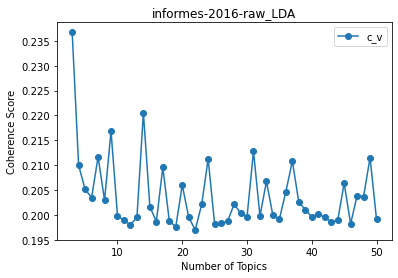

In [9]:
plot_cv(scores, corpus_label, model_label, out_dir)

In [10]:
ntopics_with_top_cv_score = scores.set_index("ntopics").c_v.idxmax()
cv_score = round(scores.c_v.max(), 2)

print(f"El modelo más coherente tiene {ntopics_with_top_cv_score} tópicos y recibió un score de c_v de {cv_score}")

El modelo más coherente tiene 3 tópicos y recibió un score de c_v de 0.24


El score de coherencia es muy bajo, es normal porque no se realizó ningún preprocesamiento del corpus.

### Lectura de los resultados

Aunque el score de coherencia sea bajo, vale la pena observar los resultados para entender cómo están conformados los modelos y a qué se debe el scoring obtenido.

Cada modelo tiene una cantidad de tópicos posibles. A su vez, cada tópico está integrado por las palabras más probables para ese tópico y la probabilidad asociada. Para visualizar toda esta información, construimos una tabla con los tópicos, las palabras y las probabilidades para el modelo que recibió el mejor scoring.

In [11]:
best_model = models[ntopics_with_top_cv_score]
tabla = make_table_all_topics(best_model, model_label, corpus_label)
tabla.head(10)

,model_name,topic_id,word_ranking,word,word_proba
0,informes-2016-raw_LDA,1,1,de,0.002868
1,informes-2016-raw_LDA,1,2,la,0.002814
2,informes-2016-raw_LDA,1,3,que,0.001971
3,informes-2016-raw_LDA,1,4,fecha,0.001747
4,informes-2016-raw_LDA,1,5,en,0.001641
5,informes-2016-raw_LDA,1,6,posición,0.001473
6,informes-2016-raw_LDA,1,7,FGS,0.001431
7,informes-2016-raw_LDA,1,8,quizás,0.001348
8,informes-2016-raw_LDA,1,9,visión,0.001348
9,informes-2016-raw_LDA,1,10,no,0.001292


Ahora, para cada tópico, visualizamos las palabras que lo componen:

In [12]:
topic_total = tabla.topic_id.unique()
for topic_id in topic_total:
    topic = tabla.query("topic_id == @topic_id")
    print(f'Tópico {topic_id}: ', " | ".join(topic.word))

Tópico 1:  de | la | que | fecha | en | posición | FGS | quizás | visión | no | perdido | es | y | el | forma | recuperar | demócratas | floating | Aurelius | blanqueo
Tópico 2:  de | la | el | en | que | a | los | y | del | se | las | por | un | una | con | para | al | lo | semana | 1
Tópico 3:  de | y | en | que | la | millones | se | USD | el | a | los | del | por | su | con | las | un | más | unos | no


Podemos observar que las palabras no tienen contenido informativo relevante y la probabilidad asociada es muy baja. En otras palabras, el modelo no es coherente. Debemos mejorar la calidad de los datos de entrada.

La forma más rápida de mejorar el input es preprocesando el corpus.

## Experiencia 2: Modelos preprocesamiento mínimo

En los resultados de la primera experiencia vimos que era necesario eliminar las palabras gramaticales que son muy frecuentes pero no aportan información temática significativa. En el ámbito del text processing estas palabras son conocidas como _stopwords_.

Otros tokens fáciles de remover son los números.

### Preprocesamiento

In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words_title = [stop_word.title() for stop_word in stop_words]
stop_words = stop_words+stop_words_title # Inicio de oración

textos_proc = [[token for token in texto if token not in stop_words] for texto in textos_tokenizados] # filtra stopwords
textos_proc = [[token for token in texto if not token.isnumeric()] for texto in textos_proc] # filtra números

### Entrenamiento

In [14]:
corpus_label = 'informes-2016'
model_label = 'clean_LDA'
models_dir = "./informes_models"

print(f"[{corpus_label}-{model_label}] Unsupervised learning")

models_proc = train_several_LDA_models(
    documentos=textos_proc,
    topic_numbers_to_try=range(3, 51),
    corpus_label=corpus_label,
    model_label=model_label,
    models_dir=out_dir,
)

[informes-2016-clean_LDA] Unsupervised learning
Already trained for 3 topics
Already trained for 4 topics
Already trained for 5 topics
Already trained for 6 topics
Already trained for 7 topics
Already trained for 8 topics
Already trained for 9 topics
Already trained for 10 topics
Already trained for 11 topics
Already trained for 12 topics
Already trained for 13 topics
Already trained for 14 topics
Already trained for 15 topics
Already trained for 16 topics
Already trained for 17 topics
Already trained for 18 topics
Already trained for 19 topics
Already trained for 20 topics
Already trained for 21 topics
Already trained for 22 topics
Already trained for 23 topics
Already trained for 24 topics
Already trained for 25 topics
Already trained for 26 topics
Already trained for 27 topics
Already trained for 28 topics
Already trained for 29 topics
Already trained for 30 topics
Already trained for 31 topics
Already trained for 32 topics
Already trained for 33 topics
Already trained for 34 topics

### Evaluación

Calculating model coherence: 100%|██████████| 48/48 [01:09<00:00,  1.44s/it]


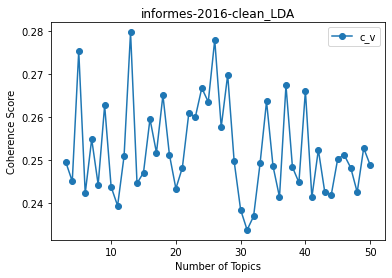

El modelo más coherente tiene 13 tópicos y recibió un score de c_v de 0.28


In [15]:
scores_proc = calculate_topic_coherence(models_proc, textos_proc, measures=["c_v"])

plot_cv(scores_proc, corpus_label, model_label, out_dir)

ntopics_with_top_cv_score = scores_proc.set_index("ntopics").c_v.idxmax()
cv_score = round(scores_proc.c_v.max(), 2)

print(f"El modelo más coherente tiene {ntopics_with_top_cv_score} tópicos y recibió un score de c_v de {cv_score}")

El score de coherencia ha aumentado pero sigue siendo bajo. La lectura humana de los tópicos del modelo de mejor scoring (13 tópicos) coincide con esta tendencia ya que, aunque encontramos palabras más informativas que en el modelo anterior, sigue siendo difícil agruparlas bajo un tópico:

In [16]:
best_model = models_proc[ntopics_with_top_cv_score]
tabla = make_table_all_topics(best_model, model_label, corpus_label)
topic_total = tabla.topic_id.unique()
for topic_id in topic_total:
    topic = tabla.query("topic_id == @topic_id")
    print(f'Tópico {topic_id}: ', " | ".join(topic.word))

Tópico 1:  días | anual | hoy | mercado | USD | plazo | dólar | Bonar | ayer | vez | Si | último | semana | bonos | tasa | mañana | subas | BCRA | tendencia | suba
Tópico 2:  semana | millones | USD | mercado | tasas | aunque | parte | ayer | caída | año | BCRA | hoy | días | datos | tasa | si | bonos | vez | petróleo | mientras
Tópico 3:  político | podría | tarde | puntos | plano | comienza | proyecciones | esperan | triunfo | menos | índice | Merval | FGS | Macri | protagonismo | Semana | sostener | Senado | nuevos | deberá
Tópico 4:  semana | USD | millones | mercado | mas | tasas | hoy | año | dato | respecto | bien | petróleo | mientras | último | días | datos | inflación | crecimiento | vez | mes
Tópico 5:  semana | USD | hoy | mercado | millones | año | plazo | vez | inflación | caída | parte | días | tasas | baja | crecimiento | respecto | ayer | mientras | tras | puntos
Tópico 6:  USD | millones | semana | mercado | parte | tasas | bonos | ayer | BCRA | hoy | año | respecto |

## Experiencia 3: Modelos preprocesamiento standard

Para seguir mejorando la calidad del corpus de entrada es posible realizar diversos tipos de preprocesamiento. A continuación veremos: adaptación de la lista de stopwords, generación de bigramas (ej. _suba dólar_, _suba tasas_, etc.) y detección de Named Entities (_Estados Unidos_, _Ministro Economía_, _Banco Central_, etc.).

### Preprocesamiento

Basados en los resultados previos, ampliamos la lista de stopwords:

In [17]:
stop_words_extra = ['si', 'tras', 'mas', 'aunque', 'u', 's']
stop_words = stop_words+stop_words_extra

textos_proc2 = [[token for token in texto if token not in stop_words] for texto in textos_proc]
print(f'El tercer documento de la colección sin procesar tiene {len(textos_tokenizados[2])} palabras.')
print(f'El tercer documento de la colección sin stopwords ni números tiene {len(textos_proc2[2])} palabras.')

El tercer documento de la colección sin procesar tiene 1212 palabras.
El tercer documento de la colección sin stopwords ni números tiene 594 palabras.


Luego generamos bigramas de palabras y agregamos al corpus los que tengan una frecuencia superior a 5

In [18]:
bigram = Phrases(textos_proc2, min_count=5)

textos_bigr = textos_proc2.copy()
for idx in range(len(textos_proc)):
    for token in bigram[textos_proc2[idx]]:
        if '_' in token:
            textos_bigr[idx].append(token)

In [19]:
textos_bigr[2]

['Noticias',
 'local',
 'alivio',
 'mercados',
 'externos',
 'suben',
 'primera',
 'vez',
 'abril',
 'Llegamos',
 'mitad',
 'semana',
 'cargada',
 'información',
 'política',
 'ámbito',
 'local',
 'detención',
 'Lázaro',
 'Báez',
 'Daniel',
 'Pérez',
 'Gadín',
 'noticia',
 'mayor',
 'impacto',
 'mañana',
 'siguen',
 'analizando',
 'derivaciones',
 'investigación',
 'Panama',
 'Papers',
 'frente',
 'económico',
 'financiero',
 'relevante',
 'pasó',
 'decisión',
 'Banco',
 'Central',
 'mantener',
 'tasa',
 'corto',
 'plazo',
 'necesidad',
 'contener',
 'tasa',
 'inflación',
 'contexto',
 'fuertes',
 'alzas',
 'precios',
 'impacto',
 'suba',
 'tarifas',
 'reducir',
 'presión',
 'tipo',
 'cambio',
 'comience',
 'liquidación',
 'exportadores',
 'externo',
 'finalmente',
 'miércoles',
 'alivio',
 'parece',
 'haber',
 'llegado',
 'mercados',
 'finalmente',
 'parecen',
 'dispuestos',
 'terminar',
 'racha',
 'caídas',
 'comenzó',
 'abril',
 'causa',
 'encontraremos',
 'vez',
 'petróleo',
 'disp

Identificamos Named Entities como 'Banco Central Europeo' y las marcamos así 'Banco_Central_Europeo'.

In [20]:
print(f"[{corpus_label}] Identify Named Entities")
spacy_nlp = spacy.load('es_core_news_lg')
textos_nlp = [spacy_nlp(' '.join(texto), disable=["tagger", "parser"]) for texto in tqdm(textos_bigr)]
textos_ner = join_named_entities(textos_nlp)

[informes-2016] Identify Named Entities


100%|██████████| 30/30 [00:00<00:00, 752.43it/s]


In [21]:
textos_ner[2]

['Noticias',
 'local',
 'alivio',
 'mercados',
 'externos',
 'suben',
 'primera',
 'vez',
 'abril',
 'Llegamos',
 'mitad',
 'semana',
 'cargada',
 'información',
 'política',
 'ámbito',
 'local',
 'detención',
 'Lázaro_Báez_Daniel_Pérez_Gadín',
 'noticia',
 'mayor',
 'impacto',
 'mañana',
 'siguen',
 'analizando',
 'derivaciones',
 'investigación',
 'Panama_Papers',
 'frente',
 'económico',
 'financiero',
 'relevante',
 'pasó',
 'decisión',
 'Banco_Central',
 'mantener',
 'tasa',
 'corto',
 'plazo',
 'necesidad',
 'contener',
 'tasa',
 'inflación',
 'contexto',
 'fuertes',
 'alzas',
 'precios',
 'impacto',
 'suba',
 'tarifas',
 'reducir',
 'presión',
 'tipo',
 'cambio',
 'comience',
 'liquidación',
 'exportadores',
 'externo',
 'finalmente',
 'miércoles',
 'alivio',
 'parece',
 'haber',
 'llegado',
 'mercados',
 'finalmente',
 'parecen',
 'dispuestos',
 'terminar',
 'racha',
 'caídas',
 'comenzó',
 'abril',
 'causa',
 'encontraremos',
 'vez',
 'petróleo',
 'disponía',
 'hoy',
 'recuper

### Entrenamiento

In [22]:
corpus_label = 'informes-2016'
model_label = '2gram_ner_LDA'
out_dir = "./informes_models"

print(f"[{corpus_label}-{model_label}] Unsupervised learning")

models_ner = train_several_LDA_models(
    documentos=textos_ner, #
    topic_numbers_to_try=range(3, 51),
    corpus_label=corpus_label,
    model_label=model_label,
    models_dir=out_dir,
)

[informes-2016-2gram_ner_LDA] Unsupervised learning
Already trained for 3 topics
Already trained for 4 topics
Already trained for 5 topics
Already trained for 6 topics
Already trained for 7 topics
Already trained for 8 topics
Already trained for 9 topics
Already trained for 10 topics
Already trained for 11 topics
Already trained for 12 topics
Already trained for 13 topics
Already trained for 14 topics
Already trained for 15 topics
Already trained for 16 topics
Already trained for 17 topics
Already trained for 18 topics
Already trained for 19 topics
Already trained for 20 topics
Already trained for 21 topics
Already trained for 22 topics
Already trained for 23 topics
Already trained for 24 topics
Already trained for 25 topics
Already trained for 26 topics
Already trained for 27 topics
Already trained for 28 topics
Already trained for 29 topics
Already trained for 30 topics
Already trained for 31 topics
Already trained for 32 topics
Already trained for 33 topics
Already trained for 34 to

### Evaluación

Calculating model coherence: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


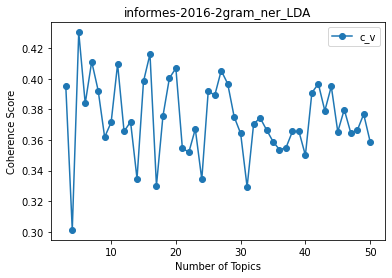

El modelo más coherente tiene 5 tópicos y recibió un score de c_v de 0.43


In [23]:
scores_ner = calculate_topic_coherence(models_ner, textos_ner, measures=["c_v"])

plot_cv(scores_ner, corpus_label, model_label, out_dir)

ntopics_with_top_cv_score = scores_ner.set_index("ntopics").c_v.idxmax()
cv_score = round(scores_ner.c_v.max(), 2)

print(f"El modelo más coherente tiene {ntopics_with_top_cv_score} tópicos y recibió un score de c_v de {cv_score}")

El score mejoró considerablemente aunque todavía está por debajo de lo que se considera aceptable.

### Visualización

Para la evaluación cualitativa e interpretación de los resultados, podemos probar una visualización con más información. Generamos entonces un gráfico interactivo donde podemos observar fácilmente cantidad de tópicos, distancia, peso y palabras de cada tópico:

In [4]:
best_model = models_ner[ntopics_with_top_cv_score]
plot_LDA_topics(best_model, textos_ner, output_path=f'{out_dir}/{corpus_label}-{model_label}.html')

El gráfico muestra tópicos próximos y hasta superpuestos. En efecto, cuando observamos las palabras que componen cada tópico, hay muchas repeticiones y agrupar las palabras de cada tópico bajo un tema es complicado. La interpretación de los resultados sigue siendo difícil, es deseable seguir mejorando el input.

## Experiencia 4: Corpus aumentado

Otra forma de mejorar los datos de entrada es sumar más textos a la colección.

In [26]:
corpus_label = 'informes-1620' # cambia la etiqueta del corpus
model_label = '2gram_ner_LDA'
out_dir = "./informes_models"

with open('informes-2016.txt', 'r') as fi:
    cont = fi.read()

with open('informes-2020.txt', 'r') as fi:
    cont += '\n\n'+fi.read()

cont = re.sub(r'»', '', cont)
cont = re.sub(r'\n\n', '', cont)
cont = re.sub(r'<soustit=[0-9]{2}>\n', '', cont)
mas_textos = re.split(r'<[^>]+>', cont)

mas_textos = [texto for texto in mas_textos if len(texto) > 1] # elimina items vacíos
print(f"El corpus tiene {len(mas_textos)} textos")

El corpus tiene 45 textos


### Preprocesamiento

In [27]:
# tokenizacion
tokenizer = RegexpTokenizer(r'\w+')
mas_textos_tokenizados = [ tokenizer.tokenize(texto) for texto in mas_textos]

from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words_extra = ['si', 'tras', 'mas', 'aunque', 'u', 's']
stop_words = stop_words+stop_words_extra
stop_words_title = [stop_word.title() for stop_word in stop_words]
stop_words = stop_words+stop_words_title

# Filtro
mas_textos_proc = [[token for token in texto if token not in stop_words] for texto in mas_textos_tokenizados] # filtra stopwords
mas_textos_proc = [[token for token in texto if not token.isnumeric()] for texto in mas_textos_proc] # filtra números

print(f'El tercer documento de la colección sin procesar tiene {len(mas_textos_tokenizados[2])} palabras.')
print(f'El tercer documento de la colección sin stopwords ni números tiene {len(mas_textos_proc[2])} palabras.')

El tercer documento de la colección sin procesar tiene 1212 palabras.
El tercer documento de la colección sin stopwords ni números tiene 591 palabras.


In [28]:
bigram = Phrases(mas_textos_proc, min_count=5)

mas_textos_bigr = mas_textos_proc.copy()
for idx in range(len(mas_textos_proc)):
    for token in bigram[mas_textos_proc[idx]]:
        if '_' in token:
            mas_textos_bigr[idx].append(token)
            
spacy_nlp = spacy.load('es_core_news_lg')
mas_textos_nlp = [spacy_nlp(' '.join(texto), disable=["tagger", "parser"]) for texto in tqdm(mas_textos_bigr)]
mas_textos_ner = join_named_entities(mas_textos_nlp)

100%|██████████| 45/45 [00:00<00:00, 671.44it/s]


### Entrenamiento

In [29]:
# Training
print(f"[{corpus_label}-{model_label}] Unsupervised learning")

models_mas_textos = train_several_LDA_models(
    documentos=mas_textos_ner,
    topic_numbers_to_try=range(3, 51),
    corpus_label=corpus_label,
    model_label=model_label,
    models_dir=out_dir,
    filter_extremes=False
)

[informes-1620-2gram_ner_LDA] Unsupervised learning
Already trained for 3 topics
Already trained for 4 topics
Already trained for 5 topics
Already trained for 6 topics
Already trained for 7 topics
Already trained for 8 topics
Already trained for 9 topics
Already trained for 10 topics
Already trained for 11 topics
Already trained for 12 topics
Already trained for 13 topics
Already trained for 14 topics
Already trained for 15 topics
Already trained for 16 topics
Already trained for 17 topics
Already trained for 18 topics
Already trained for 19 topics
Already trained for 20 topics
Already trained for 21 topics
Already trained for 22 topics
Already trained for 23 topics
Already trained for 24 topics
Already trained for 25 topics
Already trained for 26 topics
Already trained for 27 topics
Already trained for 28 topics
Already trained for 29 topics
Already trained for 30 topics
Already trained for 31 topics
Already trained for 32 topics
Already trained for 33 topics
Already trained for 34 to

### Evaluación

Calculating model coherence: 100%|██████████| 48/48 [01:31<00:00,  1.91s/it]


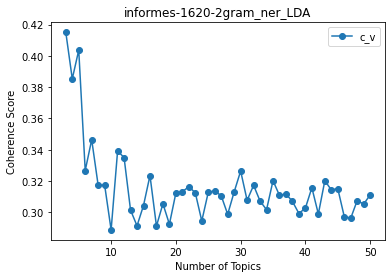

El modelo más coherente tiene 3 tópicos y recibió un score de c_v de 0.42


In [30]:
# Scoring
scores_mas_textos = calculate_topic_coherence(models_mas_textos, mas_textos_ner, measures=["c_v"])

plot_cv(scores_mas_textos, corpus_label, model_label, out_dir)

ntopics_with_top_cv_score = scores_mas_textos.set_index("ntopics").c_v.idxmax()
cv_score = round(scores_mas_textos.c_v.max(), 2)
print(f"El modelo más coherente tiene {ntopics_with_top_cv_score} tópicos y recibió un score de c_v de {cv_score}")

No hubo una mejora en el scoring de coherencia.

### Visualizacion

In [33]:
best_model = models_mas_textos[ntopics_with_top_cv_score]
plot_LDA_topics(best_model, mas_textos_ner, output_path=f'{out_dir}/{corpus_label}-{model_label}.html')

Saving topic visualization to: ./gensim_LDA_models/informes-1620-2gram_ner_LDA.html


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.089715  0.065773       1        1  55.211502
0      0.024158 -0.097011       2        1  34.705944
1     -0.113873  0.031238       3        1  10.082551, topic_info=              Term        Freq       Total Category  logprob  loglift
387   recuperación   58.000000   58.000000  Default  30.0000  30.0000
383         puntos  150.000000  150.000000  Default  29.0000  29.0000
1544  Donald_Trump   43.000000   43.000000  Default  28.0000  28.0000
2812         Trump   36.000000   36.000000  Default  27.0000  27.0000
1215         torno   68.000000   68.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
334          parte    9.540329  150.600082   Topic3  -6.0690  -0.4647
119          caída    9.154095  131.215530   Topic3  -6.1103  -0.3683
92             año    8.920054  127.358612   Topic3  -6.1362  -0.3643
2701         forma    8.300411   50.914165   Topic3  -6.2082   0.4805
515           bien    8.262367   79.486137   Topic3  -6.2128   0.0305

[257 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5003      3  0.740345          1T20
6226      2  0.957195          3T19
5005      2  0.889303          3T20
5005      3  0.084696          3T20
5719      2  0.958698          AL30
...     ...       ...           ...
2177      2  0.447190         votos
2177      3  0.351363         votos
1235      1  0.941847           yen
1235      2  0.047092           yen
5583      3  0.954943  últimos_años

[421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

Los tópicos son más distantes, comparten menos palabras y por ende son más fácilmente distinguibles entre sí. Se destaca claramente un tópico vincuado a las elecciones presidenciales de EEUU. Sin embargo, los tópicos 1 y 2 siguen siendo muy genéricos, no son son fácilmente asignables a un tema.

## Experiencia 5: Corpus aumentado + curación de recursos

Esta última experiencia combina varias estrategias: revisión manual de las Named Entities detectadas automáticamente, exclusión de hapax (palabras de que aparecen una única vez en todo el corpus) y de palabras de alta frecuencia (que aparecen en más del 50% de los documentos). Esto último se logra modificando la función 'make_dictionary_and_matrix' en 'detectar_tópicos'. 

### Carga del corpus

In [35]:
corpus_label = 'informes-1620'
model_label = 'filter_extremes_LDA'
out_dir = "./informes_models"

with open('informes-2016.txt', 'r') as fi:
    cont = fi.read()

with open('informes-2020.txt', 'r') as fi:
    cont += '\n\n'+fi.read()

cont = re.sub(r'»', '', cont)
cont = re.sub(r'\n\n', '', cont)
cont = re.sub(r'<soustit=[0-9]{2}>\n', '', cont)
mas_textos = re.split(r'<[^>]+>', cont)

mas_textos = [texto for texto in mas_textos if len(texto) > 1] # elimina items vacíos
print(f"El corpus tiene {len(mas_textos)} textos")

El corpus tiene 45 textos


### Preprocesamiento

In [36]:
# tokenizacion
tokenizer = RegexpTokenizer(r'\w+')
mas_textos_tokenizados = [ tokenizer.tokenize(texto) for texto in mas_textos]

from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words_extra = ['si', 'tras', 'hacia','mas', 'aunque', 'mientras','u', 's', 'hoy','mes', 'semana', 'día', 'año','ayer', 'vez']
stop_words = stop_words+stop_words_extra
stop_words_title = [stop_word.title() for stop_word in stop_words]
stop_words = stop_words+stop_words_title

# Filtro
mas_textos_proc = [[token for token in texto if token not in stop_words] for texto in mas_textos_tokenizados] # filtra stopwords
mas_textos_proc = [[token for token in texto if not token.isnumeric()] for texto in mas_textos_proc] # filtra números

print(f'El tercer documento de la colección sin procesar tiene {len(mas_textos_tokenizados[2])} palabras.')
print(f'El tercer documento de la colección sin stopwords ni números tiene {len(mas_textos_proc[2])} palabras.')

El tercer documento de la colección sin procesar tiene 1212 palabras.
El tercer documento de la colección sin stopwords ni números tiene 557 palabras.


In [37]:
# bigrams
bigram = Phrases(mas_textos_proc, min_count=5)

mas_textos_bigr = mas_textos_proc.copy()
for idx in range(len(mas_textos_proc)):
    for token in bigram[mas_textos_proc[idx]]:
        if '_' in token:
            mas_textos_bigr[idx].append(token)

En lugar de detectar las Named Entities automáticamente, cargamos la lista de entidades revisada manualmente:

In [38]:
print(f"[{corpus_label}] Identify Named Entities")
with open('informes_1620_NE.lst', 'r') as fi:
    entidades_curadas = fi.read().split('\n')

print(f"[{corpus_label}] Join Named Entities")
mas_textos_ner = []
for texto in mas_textos_bigr:
    texto = ' '.join(texto)
    for entity in entidades_curadas:
        entity_merged = '_'.join(entity.split())
        texto = texto.replace(entity, entity_merged)
    mas_textos_ner.append(texto.split())
    

[informes-1620] Identify Named Entities
[informes-1620] Join Named Entities


### Entrenamiento

Lanzamos el aprendizaje con `filter_extremes=True` para filtrar palabras de frecuencia muy alta y palabras de frecuencia muy baja (ver valores en la función `make_dictionary_and_matrix` de `detectar_topicos.py`):

In [41]:
print(f"[{corpus_label}-{model_label}] Unsupervised learning")

models_mas_textos = train_several_LDA_models(
    documentos=mas_textos_ner,
    topic_numbers_to_try=range(3, 51),
    corpus_label=corpus_label,
    model_label=model_label,
    models_dir=out_dir,
    filter_extremes=True
)

[informes-1620-filter_extremes_LDA] Unsupervised learning
Already trained for 3 topics
Already trained for 4 topics
Already trained for 5 topics
Already trained for 6 topics
Already trained for 7 topics
Already trained for 8 topics
Already trained for 9 topics
Already trained for 10 topics
Already trained for 11 topics
Already trained for 12 topics
Already trained for 13 topics
Already trained for 14 topics
Already trained for 15 topics
Already trained for 16 topics
Already trained for 17 topics
Already trained for 18 topics
Already trained for 19 topics
Already trained for 20 topics
Already trained for 21 topics
Already trained for 22 topics
Already trained for 23 topics
Already trained for 24 topics
Already trained for 25 topics
Already trained for 26 topics
Already trained for 27 topics
Already trained for 28 topics
Already trained for 29 topics
Already trained for 30 topics
Already trained for 31 topics
Already trained for 32 topics
Already trained for 33 topics
Already trained for

### Evaluación

Calculating model coherence: 100%|██████████| 48/48 [01:23<00:00,  1.74s/it]


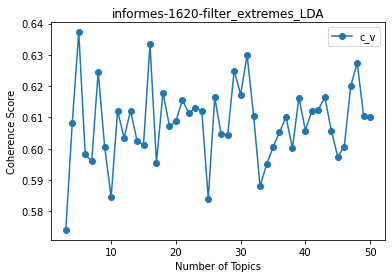

El modelo más coherente tiene 5 tópicos y recibió un score de c_v de 0.64


In [42]:
scores_mas_textos = calculate_topic_coherence(models_mas_textos, mas_textos_ner, measures=["c_v"], filter_extremes=True)

plot_cv(scores_mas_textos, corpus_label, model_label, out_dir)

ntopics_with_top_cv_score = scores_mas_textos.set_index("ntopics").c_v.idxmax()
cv_score = round(scores_mas_textos.c_v.max(), 2)
print(f"El modelo más coherente tiene {ntopics_with_top_cv_score} tópicos y recibió un score de c_v de {cv_score}")

El valor de cv es bueno, la lectura de los tópicos arrojará interpretaciones más fructíferas.

### Visualización

In [58]:
best_model = models_mas_textos[ntopics_with_top_cv_score]
plot_LDA_topics(best_model, mas_textos_ner, output_path=f'{out_dir}/{corpus_label}-{model_label}.html', filter_extremes=True)

Estos resultados muestran palabras informativamente relevantes agrupadas por temáticas similares. La brecha temporal en el corpus también se ve representada por la separación de los tópicos en el eje horizontal.

Encontramos 5 tópicos de los cuales 2 se superponen. Estos tópicos superpuestos tratan de la cuestión de los holdouts (tema relevante para las finanzas en 2016). Los demás tópicos se distancian claramente y corresponden a temas de 2020: elecciones presidenciales estadounidenses (tópico 4), incertidumbre de octubre (tópico 2) y crisis económica 2020 (tópico 5).